In [ ]:
import json
import pandas as pd
import matplotlib.pyplot as plt
import warnings
from matplotlib.ticker import MaxNLocator

warnings.simplefilter(action='ignore', category=FutureWarning)


short_hedge = True

def get_weakest_n(n):
    def extract_symbol_quantity(cell_value):
        symbol, rs_value = cell_value.split('_')
        return symbol, float(rs_value)

    date_to_symbol = {}
    for time_interval in ['8h']:
        df = pd.read_csv(f'rs_value_{time_interval}.csv', index_col=0)

        len_col = len(df.columns)
        for _, row in df.iterrows():
            date = row['date']
            for column in df.columns[1:n+1]: # get weakest top-n
                cell = row[column]
                symbol, rs_value = extract_symbol_quantity(cell)
                if rs_value == 0: # 0 means no data
                    continue
                date_to_symbol[date] = symbol
    return date_to_symbol

with open('backtest_result.json') as f:
    data = json.load(f)

date_to_weakest_symbol = get_weakest_n(1)
# daily_return = {}

# start_date = '2024-06-01 00:00:00'
# end_date = '2024-06-05 00:00:00'

# date_range = pd.date_range(start=start_date, end=end_date, freq='H')

# for date in date_range:
#     daily_return[date] = 0

rows = []
for symbol in data.keys():    
    df = pd.read_json(data[symbol])
    try:
        df = df.drop(columns=['open', 'high', 'low', 'volume', 'ATR'])
    except:
        print(symbol, ' error')
        continue

    # print(symbol)
    # print(df.to_string())

    row = {}
    temp = []
    entry_price = 0
    exit_price = 0
    # print(df['signal'])
    for idx, value in df.iterrows():
        # print(idx, value)
        if value['signal'] == 1:
            temp.append(idx)  # Start of a new pairs
            entry_price = value['close']
            entry_date = value['date']
            entry_datetime = value['datetime']
        elif value['signal'] == -1 and temp:
            temp.append(idx)  # End of the pair
            exit_price = value['close']
            exit_date = value['date']
            exit_datetime = value['datetime']
            row['symbol'] = symbol
            row['entry_price'] = entry_price
            row['entry_date'] = entry_date
            row['entry_datetime'] = entry_datetime
            row['exit_price'] = exit_price
            row['exit_date'] = exit_date
            row['exit_datetime'] = exit_datetime
            
            if short_hedge:
                weakest_symbol = date_to_weakest_symbol[row['entry_date'].strftime('%Y-%m-%d')]
                weakest_df = pd.read_csv(f'./data/UPERP/1h/{weakest_symbol}_UPERP_1h.csv') # datetime,open,high,low,close,volume
                weakest_df['datetime'] = pd.to_datetime(weakest_df['datetime']) # format=2024/05/04 12:00:00
                weakest_df_entry_price = weakest_df[weakest_df['datetime'] == row['entry_datetime']]['close'].iloc[0]
                weakest_df_exit_price = weakest_df[weakest_df['datetime'] == row['exit_datetime']]['close'].iloc[0]
                row['weakest_short_symbol'] = weakest_symbol
                row['weakest_short_profit'] = (weakest_df_entry_price - weakest_df_exit_price) * (100 / weakest_df_entry_price)
            else:
                row['weakest_short_profit'] = 0
            
            rows.append(row)
            row = {}
            temp = []  # Reset for the next pair


result_df = pd.DataFrame(rows)
result_df['profit'] = (result_df['exit_price'] - result_df['entry_price']) * (100 / result_df['entry_price'])
# result_df['profit'] = (result_df['entry_price'] - result_df['exit_price']) * (100 / result_df['entry_price'])
result_df['profit_plus_weakest_short'] = result_df['profit'] + result_df['weakest_short_profit']
result_df.sort_values(by='entry_datetime', ascending=True, inplace=True)
result_df['cum_profit'] = result_df['profit'].cumsum()
result_df['cum_profit_plus_weakest_short'] = result_df['profit_plus_weakest_short'].cumsum()
result_df['cum_weakest_short_profit'] = result_df['weakest_short_profit'].cumsum()
print(result_df.to_string())
print(result_df['cum_profit'])
print(result_df['cum_profit_plus_weakest_short'])

result_df['entry_date'] = pd.to_datetime(result_df['entry_date'])
result_df['exit_date'] = pd.to_datetime(result_df['exit_date'])
result_df['entry_datetime'] = pd.to_datetime(result_df['entry_datetime'])
result_df['exit_datetime'] = pd.to_datetime(result_df['exit_datetime'])

grouped = result_df.groupby('exit_date')['profit'].sum().reset_index()

# Convert to dictionary
cum_profit_dict = dict(zip(grouped['exit_date'].dt.strftime('%Y-%m-%d'), grouped['profit']))

# Print the resulting dictionary
print(cum_profit_dict)

# Plotting cumulative profit
plt.figure(figsize=(10, 6))
# plt.plot(cum_profit_dict.keys(), cum_profit_dict.values(), marker='o', linestyle='-', color='b')
plt.plot(result_df['entry_date'], result_df['cum_profit_plus_weakest_short'], marker='o', linestyle='-', color='b', label='profit_with_short')
plt.plot(result_df['entry_date'], result_df['cum_profit'], marker='o', linestyle='-', color='r', label='profit')
plt.plot(result_df['entry_date'], result_df['cum_weakest_short_profit'], marker='o', linestyle='-', color='g', label='only_short')
plt.title('Cumulative Profit Over Time')
plt.xlabel('Entry Date')
plt.ylabel('Cumulative Profit')
plt.grid(True)

ax = plt.gca()
ax.xaxis.set_major_locator(MaxNLocator(nbins=6))

plt.xticks(rotation=45)
plt.tight_layout()
plt.legend(loc="upper left")
plt.show()

Maximum Drawdown (MDD) as Percentage: 19.46%
Win Rate: 46.39%
Profit Factor: 1.57
Average Opened Trades per Day:  1.7431693989071038
Average Active Positions per Day:  3.191256830601093


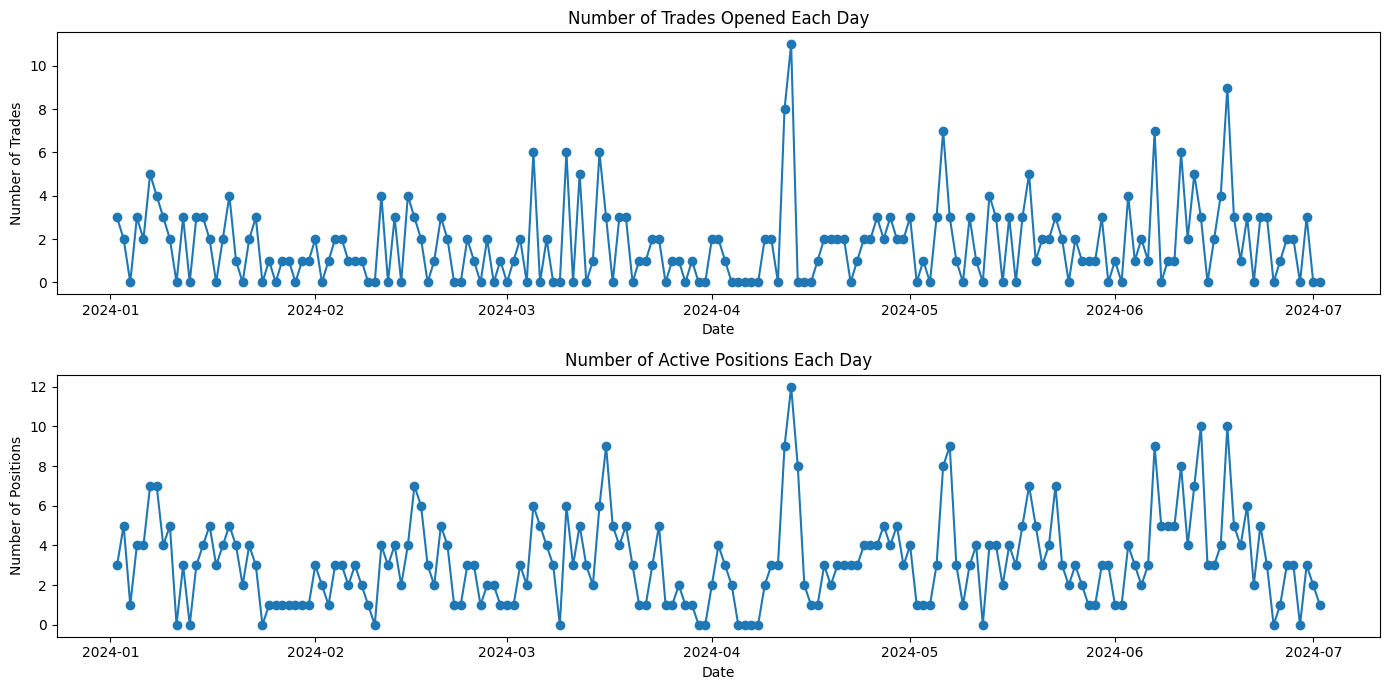

In [7]:
import numpy as np

def calculate_metrics(profit_list):
    # Calculate cumulative profit
    cum_profit = np.cumsum(profit_list)
    
    # Calculate MDD as a percentage
    max_cum_profit = np.maximum.accumulate(cum_profit)
    drawdown = max_cum_profit - cum_profit
    mdd = np.max(drawdown)
    max_peak = np.max(max_cum_profit)
    mdd_percent = (mdd / max_peak) * 100 if max_peak != 0 else 0
    
    # Calculate Win Rate
    wins = [p for p in profit_list if p > 0]
    losses = [p for p in profit_list if p <= 0]
    win_rate = len(wins) / len(profit_list) if profit_list else 0
    
    # Calculate Profit Factor
    gross_profit = sum(wins)
    gross_loss = abs(sum(losses))
    profit_factor = gross_profit / gross_loss if gross_loss != 0 else float('inf')
    
    return mdd_percent, win_rate, profit_factor

# Example usage
profit_list = [100, -50, 200, -300, 150, 50, -100]
mdd_percent, win_rate, profit_factor = calculate_metrics(result_df['profit'].to_list())

print(f"Maximum Drawdown (MDD) as Percentage: {mdd_percent:.2f}%")
print(f"Win Rate: {win_rate * 100:.2f}%")
print(f"Profit Factor: {profit_factor:.2f}")


# 計算開倉次數 以及 部位數量
date_range = pd.date_range(start=result_df['entry_datetime'].min().date(), end=result_df['exit_datetime'].max().date())

# Count trades opened and positions held each day
opened_trades = {date: 0 for date in date_range}
active_positions = {date: 0 for date in date_range}

for date in date_range:
    opened_trades[date] = result_df[(result_df['entry_datetime'].dt.date == date.date())].shape[0]
    active_positions[date] = result_df[(result_df['entry_datetime'].dt.date <= date.date()) & (result_df['exit_datetime'].dt.date >= date.date())].shape[0]

# Convert to DataFrame
opened_trades_df = pd.DataFrame(list(opened_trades.items()), columns=['Date', 'Opened Trades'])
active_positions_df = pd.DataFrame(list(active_positions.items()), columns=['Date', 'Active Positions'])

print('Average Opened Trades per Day: ', opened_trades_df['Opened Trades'].mean())
print('Average Active Positions per Day: ', active_positions_df['Active Positions'].mean())
# Plot the data
plt.figure(figsize=(14, 7))

plt.subplot(2, 1, 1)
plt.plot(opened_trades_df['Date'], opened_trades_df['Opened Trades'], marker='o')
plt.title('Number of Trades Opened Each Day')
plt.xlabel('Date')
plt.ylabel('Number of Trades')

plt.subplot(2, 1, 2)
plt.plot(active_positions_df['Date'], active_positions_df['Active Positions'], marker='o')
plt.title('Number of Active Positions Each Day')
plt.xlabel('Date')
plt.ylabel('Number of Positions')

plt.tight_layout()
plt.show()


/var/folders/4n/zfrhjs69041cfv2bqdvyl28w0000gn/T/ipykernel_50602/920226943.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df['entry_datetime'] = pd.to_datetime(plot_df['entry_datetime'])
/var/folders/4n/zfrhjs69041cfv2bqdvyl28w0000gn/T/ipykernel_50602/920226943.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_df['exit_datetime'] = pd.to_datetime(plot_df['exit_datetime'])


                       open    high     low   close     volume
datetime                                                      
2023-02-16 14:00:00  0.4465  0.4510  0.4368  0.4486  4388386.0
2023-02-16 15:00:00  0.4484  0.4700  0.4460  0.4630  6105628.0
2023-02-16 16:00:00  0.4628  0.4698  0.4416  0.4567  6745079.0
2023-02-16 17:00:00  0.4562  0.4593  0.4501  0.4546  1830972.0
2023-02-16 18:00:00  0.4544  0.4612  0.4523  0.4575  1761714.0
...                     ...     ...     ...     ...        ...
2024-07-12 12:00:00  0.7009  0.7009  0.7009  0.7009        0.0
2024-07-12 13:00:00  0.7009  0.7009  0.7009  0.7009        0.0
2024-07-12 14:00:00  0.7009  0.7009  0.7009  0.7009        0.0
2024-07-12 15:00:00  0.7009  0.7009  0.7009  0.7009        0.0
2024-07-12 16:00:00  0.7009  0.7009  0.7009  0.7009        0.0

[12336 rows x 5 columns]
                       open    high     low   close      volume
datetime                                                       
2024-03-04 18:00:00  0.8546

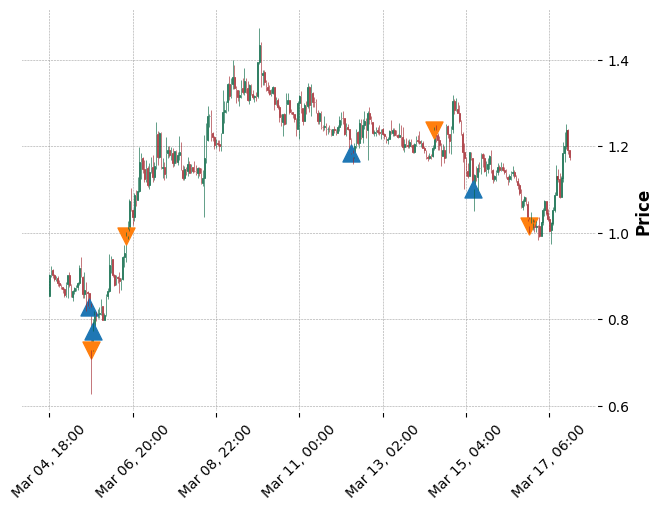

In [137]:
import os
import mplfinance as mpf
import matplotlib.pyplot as plt

target_symbol = 'AGIXUSDT'
plot_df = result_df[result_df['symbol'] == target_symbol]
# print(plot_df)
plot_df['entry_datetime'] = pd.to_datetime(plot_df['entry_datetime'])
plot_df['exit_datetime'] = pd.to_datetime(plot_df['exit_datetime'])


filename = f'./data/UPERP/1h/{target_symbol}_UPERP_1h.csv'
if not os.path.isfile(filename):
    print('{symbol} csv not found')
    raise

target_symbol_df = pd.read_csv(filename) # datetime,open,high,low,close,volume
target_symbol_df['datetime'] = pd.to_datetime(target_symbol_df['datetime']) # format=2024/05/04 12:00:00
target_symbol_df.set_index('datetime', inplace=True)

print(target_symbol_df)
# print(plot_df.head())

# Filter target symbol data
# first_trade_entry = plot_df['entry_datetime'].min()
# last_trade_exit = plot_df['exit_datetime'].max()
first_trade_entry = plot_df['entry_datetime'].iloc[5]
last_trade_exit = plot_df['exit_datetime'].iloc[8]

# start_date = first_trade_entry - pd.Timedelta(hours=48)
# end_date = first_trade_entry + pd.Timedelta(hours=48)
start_date = first_trade_entry - pd.Timedelta(hours=24)
end_date = last_trade_exit + pd.Timedelta(hours=24)

# Filter target symbol data
candlestick_df = target_symbol_df[(target_symbol_df.index >= start_date) & (target_symbol_df.index <= end_date)]
candlestick_df = candlestick_df[['open', 'high', 'low', 'close', 'volume']]

plot_df = plot_df[plot_df['symbol'] == target_symbol]
plot_df = plot_df[(plot_df['entry_datetime'] >= start_date) & (plot_df['entry_datetime'] <= end_date) &
                  (plot_df['exit_datetime'] >= start_date) & (plot_df['exit_datetime'] <= end_date)]
print(candlestick_df.to_string())
# print(plot_df.head())
entry_df = plot_df[['entry_datetime', 'entry_price']]
entry_df.index = entry_df['entry_datetime']
candlestick_df['entry_price'] = candlestick_df.index.map(entry_df['entry_price'])

exit_df = plot_df[['exit_datetime', 'exit_price']]
exit_df.index = exit_df['exit_datetime']
candlestick_df['exit_price'] = candlestick_df.index.map(exit_df['exit_price'])

# print(tmp_df['exit_datetime'])
print(candlestick_df['exit_price'].to_list())
entry_subplot = mpf.make_addplot(candlestick_df['entry_price'].to_list(), type='scatter', markersize=150, marker='^')
exit_subplot = mpf.make_addplot(candlestick_df['exit_price'].to_list(), type='scatter', markersize=150, marker='v')
# print(candlestick_df.to_string())
mpf.plot(candlestick_df, type='candle', style='charles', addplot=[entry_subplot, exit_subplot])
# for index, row in plot_df.iterrows():
#     if row['symbol'] == target_symbol:
#         entry_datetime = row['entry_datetime']
#         exit_datetime = row['exit_datetime']
#         entry_price = row['entry_price']
#         exit_price = row['exit_price']
#         if start_date <= entry_datetime <= end_date and start_date <= exit_datetime <= end_date:
#             print(entry_datetime)
#             mpf.make_addplot(data, type='scatter')
#             ax.plot(entry_datetime, 1, marker='o', markersize=5, color='green', label='Entry' if index == 0 else "")
            # ax.plot(exit_datetime, 1, marker='x', markersize=5, color='red', label='Exit' if index == 0 else "")

# Add legend
# handles, labels = ax.get_legend_handles_labels()
# by_label = dict(zip(labels, handles))
# ax.legend(by_label.values(), by_label.keys())

# Show plot
plt.show()



In [ ]:
# 做多 同時空最弱的
def get_weakest_n(n):
    def extract_symbol_quantity(cell_value):
        symbol, rs_value = cell_value.split('_')
        return symbol, float(rs_value)

    n_dict = {}
    for time_interval in ['4h']:
        df = pd.read_csv(f'rs_value_{time_interval}.csv', index_col=0)

        len_col = len(df.columns)
        for _, row in df.iterrows():
            date = row['date']
            for column in df.columns[1:n+1]: # get weakest top-n
                cell = row[column]
                symbol, rs_value = extract_symbol_quantity(cell)
                if rs_value == 0: # 0 means no data
                    continue
                if symbol not in n_dict:
                    n_dict[symbol] = set() # prevent duplicate date
                n_dict[symbol].add(date)
    return n_dict